## 트랜스 포머를 이용한 음악생성

- 파라메터

In [2]:
import sys
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/01_transformer/transformer_utils.py
    # output 디렉토리를 만듭니다.
    !mkdir bach-cello
    !mkdir parsed_data
    !mkdir models
    !mkdir output
    # 악보 이미지 생성을 위해
    !apt-get install lilypond > /dev/null

--2024-04-03 12:01:15--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/01_transformer/transformer_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6876 (6.7K) [text/plain]
Saving to: ‘transformer_utils.py’

transformer_utils.p 100%[===================>]   6.71K  --.-KB/s    in 0s      

2024-04-03 12:01:16 (64.3 MB/s) - ‘transformer_utils.py’ saved [6876/6876]

Extracting templates from packages: 100%


In [3]:
# 필요한 라이브러리
import os
import glob
import numpy as np
import time
import sys
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils  import(
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding
)

In [4]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = './parsed_data'
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# 최적화
EPOCHS = 20
BATCH_SIZE = 256
GENERATE_LEN = 50

In [5]:
if 'google.colab' in sys.modules:
    %cd ./bach-cello/
    !curl -O http://www.jsbach.net/midi/cs1-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-5men.mid -s
    !curl -O http://www.jsbach.net/midi/cs1-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-5men.mid -s
    !curl -O http://www.jsbach.net/midi/cs2-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-5bou.mid -s
    !curl -O http://www.jsbach.net/midi/cs3-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-5bou.mid -s
    !curl -O http://www.jsbach.net/midi/cs4-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-5gav.mid -s
    !curl -O http://www.jsbach.net/midi/cs5-6gig.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-1pre.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-2all.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-3cou.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-4sar.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-5gav.mid -s
    !curl -O http://www.jsbach.net/midi/cs6-6gig.mid -s
    %cd ..

/content/bach-cello
/content


In [6]:
# 데이터 로드
file_list = glob.glob("./bach-cello/*.mid")
len(file_list)

36

In [7]:
parser = music21.converter

In [8]:
example_score = music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()

In [9]:
from IPython.display import Image, Audio

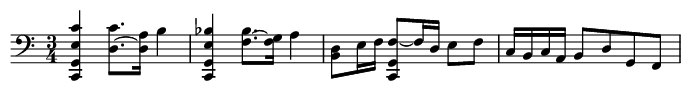

In [10]:
display(Image(str(example_score.write('lily.png'))))

In [11]:
example_score.show('text')

{0.0} <music21.metadata.Metadata object at 0x7f8d36220550>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark grave Quarter=40>
    {0.0} <music21.key.Key of C major>
    {0.0} <music21.meter.TimeSignature 3/4>
    {0.0} <music21.chord.Chord C2 G2 E3 C4>
    {1.0} <music21.chord.Chord D3 C4>
    {1.75} <music21.chord.Chord D3 A3>
    {2.0} <music21.chord.Chord B3>
{3.0} <music21.stream.Measure 2 offset=3.0>
    {0.0} <music21.chord.Chord C2 G2 E3 B-3>
    {1.0} <music21.chord.Chord F3 B-3>
    {1.75} <music21.chord.Chord F3 G3>
    {2.0} <music21.chord.Chord A3>
{6.0} <music21.stream.Measure 3 offset=6.0>
    {0.0} <music21.chord.Chord B2 D3>
    {0.5} <music21.chord.Chord E3>
    {0.75} <music21.chord.Chord F3>
    {1.0} <music21.chord.Chord C2 G2 F3>
    {1.5} <music21.chord.Chord F3>
    {1.75} 

In [12]:
if PARSE_MIDI_FILES:
  notes,durations = parse_midi_files(
      file_list, parser, SEQ_LEN+1, PARSED_DATA_PATH
  )
else:
  notes,durations = load_parsed_files()

1 ./bach-cello/cs3-6gig.mid 파싱


<ipython-input-12-248aee80d70d>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes,durations = parse_midi_files(


961개 음표 파싱
2 ./bach-cello/cs3-4sar.mid 파싱
1302개 음표 파싱
3 ./bach-cello/cs1-2all.mid 파싱
2223개 음표 파싱
4 ./bach-cello/cs6-2all.mid 파싱
2908개 음표 파싱
5 ./bach-cello/cs2-6gig.mid 파싱
3643개 음표 파싱
6 ./bach-cello/cs2-3cou.mid 파싱
4384개 음표 파싱
7 ./bach-cello/cs6-6gig.mid 파싱
5556개 음표 파싱
8 ./bach-cello/cs4-5bou.mid 파싱
6880개 음표 파싱
9 ./bach-cello/cs1-5men.mid 파싱
7527개 음표 파싱
10 ./bach-cello/cs2-2all.mid 파싱
8220개 음표 파싱
11 ./bach-cello/cs1-3cou.mid 파싱
9040개 음표 파싱
12 ./bach-cello/cs5-5gav.mid 파싱
10242개 음표 파싱
13 ./bach-cello/cs2-1pre.mid 파싱
10880개 음표 파싱
14 ./bach-cello/cs6-1pre.mid 파싱
12222개 음표 파싱
15 ./bach-cello/cs3-2all.mid 파싱
12959개 음표 파싱
16 ./bach-cello/cs1-4sar.mid 파싱
13222개 음표 파싱
17 ./bach-cello/cs5-6gig.mid 파싱
13671개 음표 파싱
18 ./bach-cello/cs4-1pre.mid 파싱
14488개 음표 파싱
19 ./bach-cello/cs3-5bou.mid 파싱
15369개 음표 파싱
20 ./bach-cello/cs4-6gig.mid 파싱
16340개 음표 파싱
21 ./bach-cello/cs4-4sar.mid 파싱
16660개 음표 파싱
22 ./bach-cello/cs5-1pre.mid 파싱
17969개 음표 파싱
23 ./bach-cello/cs5-4sar.mid 파싱
18188개 음표 파싱
24 ./bach-cello/c

In [13]:
example_notes = notes[658]
example_durations = durations[658]
example_notes,example_durations

('A3 B3 E3 G3 C4 A3 B-3 G3 A3 F3 D3 F3 E3 D3 G3 D3 B2 A2 G2 F2 E2 G2 C3 E2 D2 B2 C3 E3 G3 C4 D4 C4 B3 C4 A3 B3 G3 A3 F3 G3 E3 F3 D3 E3 C3 G3 A3 B3 C4 D4 E4',
 '0.5 0.5 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.5 0.5 0.5 1.0 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.5')

데이터 토큰화

In [14]:
def create_dataset(elements):
  ds = (
      tf.data.Dataset.from_tensor_slices(elements)
      .batch(BATCH_SIZE,drop_remainder=True)
      .shuffle(1000)
  )
  vectorize_layer = layers.TextVectorization(
      standardize=None, output_mode = 'int'
  )
  vectorize_layer.adapt(ds)
  vocab = vectorize_layer.get_vocabulary()
  return ds, vectorize_layer, vocab

notes_seq_ds, notes_vectorize_layer, notes_vocab =  create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(durations)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))


In [15]:
# 동일한 음표과 지속시간을 int로 변환해서 표시
example_tokenised_notes =  notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print(f"{'note token':<10} {'duration token'}")
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
  ):
  print(f"{note_int:>5} {duration_int:>10}")


note token duration token
    3          3
    9          3
    7          2
    2          2
    6          2
    3          2
   11          2
    2          2
    3          2
    5          2
    4          2


In [16]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# token:note 매핑 예시를 출력합니다.
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: E3
8: D4
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


훈련 세트 생성

In [17]:
# 시퀀스와 하나의 음표를 이동한 동일한 시퀀스로 훈련 세트를 만듦
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [18]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[37, 50, 53, ..., 19,  6,  6],
       [50, 53, 33, ...,  6,  6,  7],
       [53, 33,  2, ...,  6,  7, 12],
       ...,
       [19,  6,  6, ...,  4, 18,  4],
       [ 6,  6,  7, ..., 18,  4, 19],
       [ 6,  7, 12, ...,  4, 19,  4]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [3, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[50, 53, 33, ...,  6,  6,  7],
       [53, 33,  2, ...,  6,  7, 12],
       [33,  2,  6, ...,  7, 12,  4],
       ...,
       [ 6,  6,  7, ..., 18,  4, 19],
       [ 6,  7, 12, ...,  4, 19,  4],
       [ 7, 12,  4, ..., 19,  4, 18]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,

- 코잘 어텐션 마스크 함수

In [19]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

- 트랜스포커 블록 층

In [20]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads    # 어텐션 해드 개수
        self.key_dim = key_dim        # 어텐션 키의 차원
        self.embed_dim = embed_dim    # 임베딩 차원
        self.ff_dim = ff_dim          # 피드포워드 신경망의 차원
        self.dropout_rate = dropout_rate      # 드랍아웃 비율
        # 신경망 초기화
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        # 코잘 어텐션 마스크 생성
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        # 멀티 해드 어텐션 수행
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        # 레지듀얼 커넥션과 정규화
        out1 = self.ln_1(inputs + attention_output)
        # 피드포워드 신경망 수행
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        # 두번째 레지듀얼 커넥션과 정규화
        return (self.ln_2(out1 + ffn_output), attention_scores)

    # 설정함수, 모델의 설정을 반환
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

토큰과 위치 임베딩

In [21]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

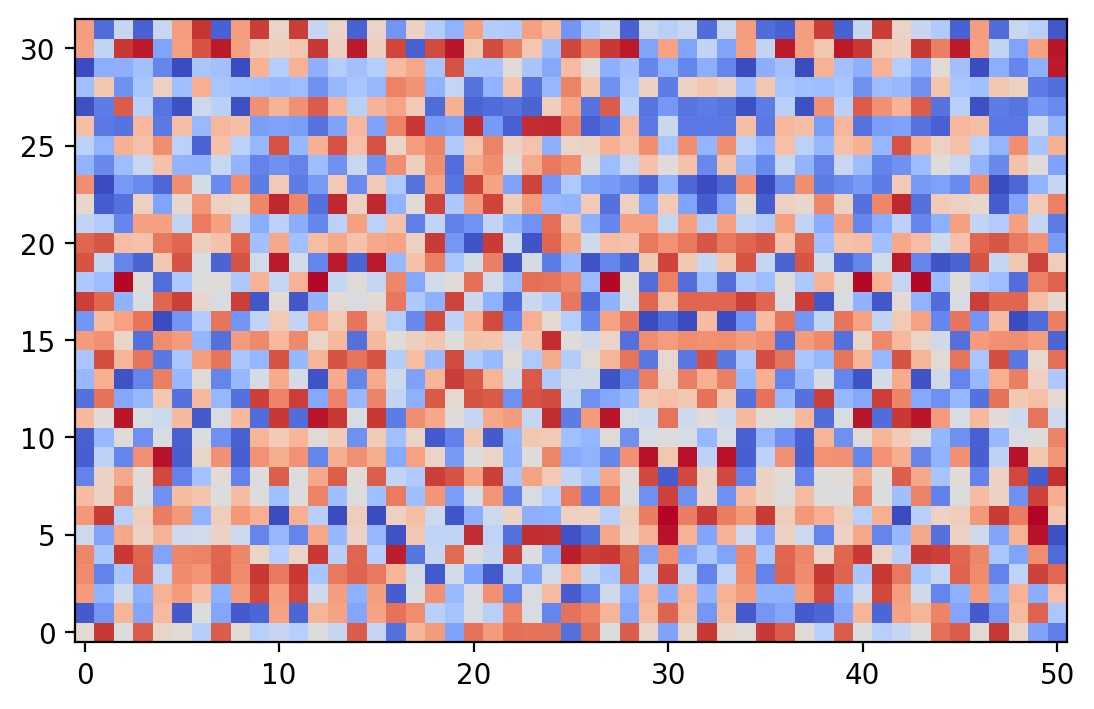

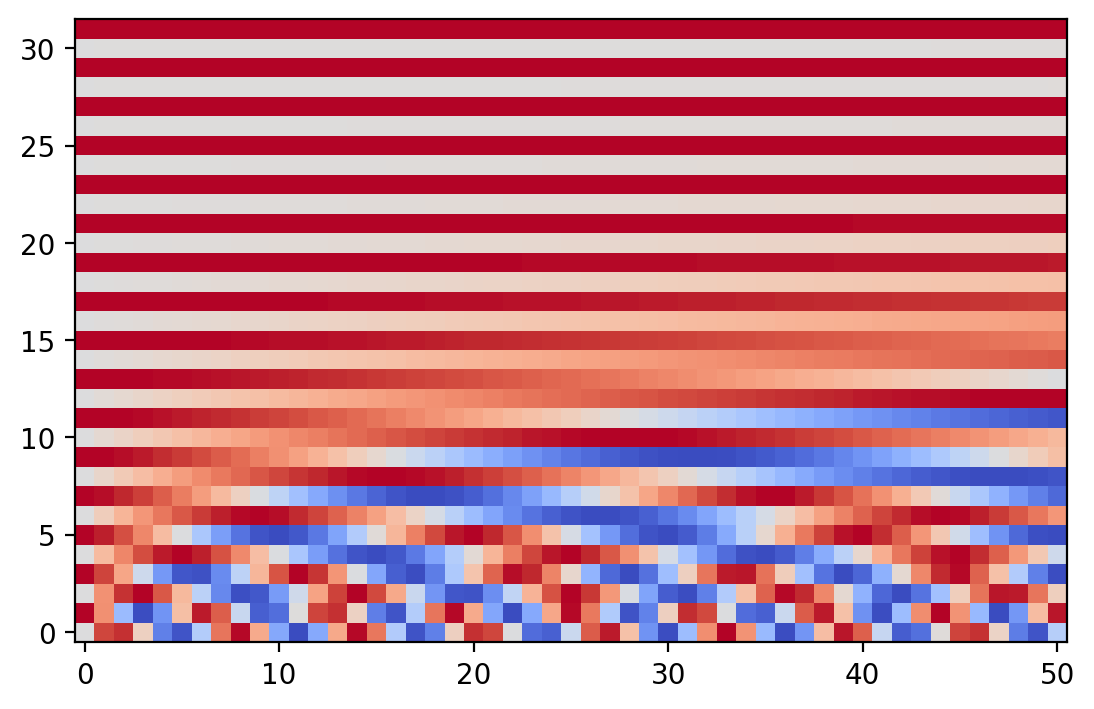

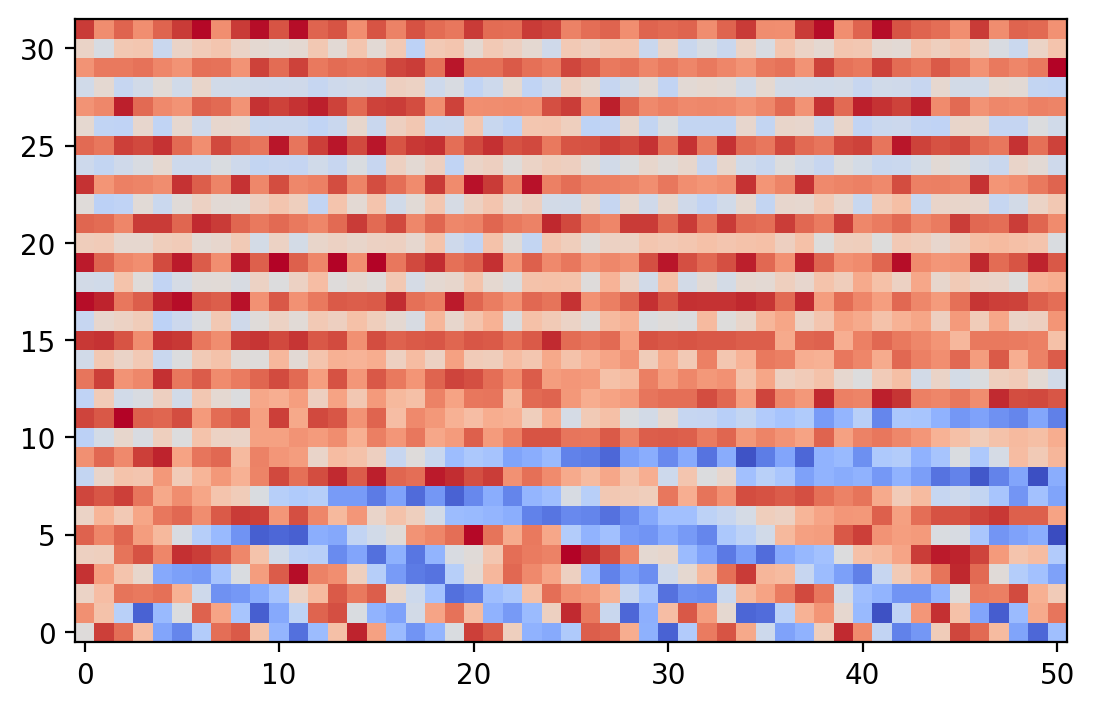

In [22]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

트랜스포머 모델 구축

In [23]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention")(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs")(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs")(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 token_and_position_embeddi  (None, None, 128)            7552      ['input_1[0][0]']             
 ng_1 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                              

In [25]:
if LOAD_MODEL:
  model.load_weights("./checkpoint/checkpoint.ckpt")

트랜스포머 훈련하기

In [26]:
# MusicGenerator 체크포인트 만들기
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])

        display(Image(str(midi_stream.write('lily.png'))))
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "./output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

- 모델 저장 체크포인트 만들기

In [27]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='./checkpoint/checkpoint.ckpt',
    save_weights_only=True,
    save_freq='epoch',
    verbose=0
)
tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')
# 시작프롬프트 토큰화
music_generator = MusicGenerator(notes_vocab, durations_vocab)

Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 4.9008 - note_outputs_loss: 3.4818 - duration_outputs_loss: 1.4190[['START', 'D4', 'E3', 'E-3', 'C4', 'G#3', 'B-3', 'G3', 'G3', 'G3', 'G#3', 'E3', 'B-3', 'D3', 'F3', 'G2', 'G3', 'B-3', 'G3', 'C4', 'F3', 'B-3', 'E-4', 'G3', 'F3', 'G3', 'B-3', 'G3', 'G3', 'A3', 'G3', 'E-3', 'B-3', 'D4', 'D4', 'B-3', 'B-3', 'G3', 'B-3', 'G#3', 'D3', 'E-3', 'B-3', 'E-3', 'C3', 'B3', 'G#3', 'G3', 'D4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


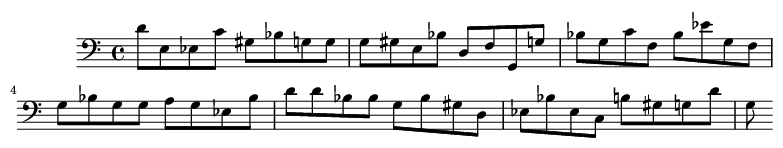

107/107 [==============================] - 26s 166ms/step - loss: 4.9008 - note_outputs_loss: 3.4818 - duration_outputs_loss: 1.4190
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 4.1124 - note_outputs_loss: 3.2925 - duration_outputs_loss: 0.8200[['START', 'G3', 'B-3', 'E3', 'F3', 'E3', 'F3', 'A2', 'F3', 'D3', 'D3', 'D3', 'C3', 'F3', 'E3', 'D3', 'F3', 'C3', 'F3', 'G3', 'F3', 'D3', 'G3', 'F3', 'F3', 'D3', 'F#3', 'A3', 'F3', 'D3', 'D3', 'C3', 'F3', 'F3', 'D3', 'A3', 'B2', 'B2', 'F3', 'D3', 'E3', 'D3', 'E3', 'D3', 'D3', 'D3', 'B2', 'D3', 'C3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


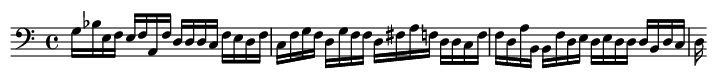

107/107 [==============================] - 15s 143ms/step - loss: 4.1124 - note_outputs_loss: 3.2925 - duration_outputs_loss: 0.8200
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 3.6375 - note_outputs_loss: 2.9632 - duration_outputs_loss: 0.6743[['START', 'D3', 'E3', 'F3', 'G3', 'F3', 'D3', 'F3', 'G3', 'C4', 'B-3', 'D3', 'E3', 'D3', 'F3', 'G3', 'F3', 'G3', 'F3', 'G3', 'F3', 'D3', 'E3', 'F3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'F3', 'F3', 'G3', 'F3', 'G3', 'F3', 'G3', 'F3', 'G3', 'F3', 'D3', 'F3', 'G3', 'F3', 'C3', 'C3', 'G3', 'F3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


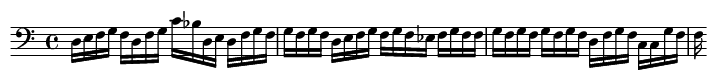

107/107 [==============================] - 15s 142ms/step - loss: 3.6375 - note_outputs_loss: 2.9632 - duration_outputs_loss: 0.6743
Epoch 4/20
107/107 [==============================] - ETA: 0s - loss: 3.4278 - note_outputs_loss: 2.7701 - duration_outputs_loss: 0.6576[['START', 'A4', 'F#4', 'A3', 'E4', 'F#4', 'F#4', 'E4', 'F#4', 'F#4', 'A3', 'F#4', 'E4', 'F#4', 'F#4', 'D4', 'A3', 'A3', 'A3', 'E4', 'D4', 'A3', 'A3', 'G3', 'E3', 'A3', 'A3', 'A3', 'E3', 'F3', 'G3', 'A3', 'G3', 'A3', 'G3', 'F3', 'G3', 'G#3', 'D3', 'E-3', 'D3', 'E-3', 'E-3', 'D3', 'E-3', 'D3', 'E-3', 'D3', 'E-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


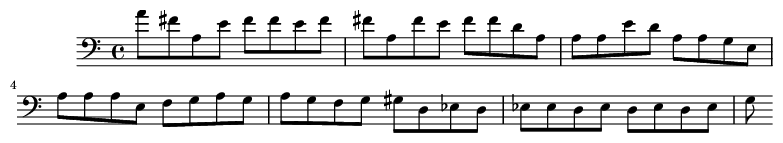

107/107 [==============================] - 15s 141ms/step - loss: 3.4278 - note_outputs_loss: 2.7701 - duration_outputs_loss: 0.6576
Epoch 5/20
107/107 [==============================] - ETA: 0s - loss: 3.2411 - note_outputs_loss: 2.6277 - duration_outputs_loss: 0.6135[['START', 'A4', 'E5', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'G#4', 'E4', 'D4', 'C#4', 'D4', 'C#4', 'C#4', 'D4', 'E4', 'E4', 'G4', 'E4', 'E4', 'D4', 'E4', 'E4', 'E4', 'E4', 'E4', 'C#4', 'D4', 'C#4', 'E4', 'D4', 'E4', 'E4', 'E4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'E4', 'A3', 'C#4', 'D4', 'C#4', 'D4'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


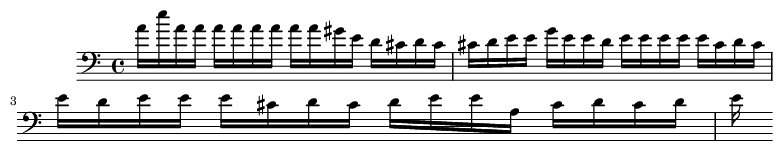

107/107 [==============================] - 15s 144ms/step - loss: 3.2411 - note_outputs_loss: 2.6277 - duration_outputs_loss: 0.6135
Epoch 6/20
107/107 [==============================] - ETA: 0s - loss: 3.1406 - note_outputs_loss: 2.5503 - duration_outputs_loss: 0.5903[['START', '3/4TS', 'G:major', '4/4TS', 'D:major', 'E-:major', '4/4TS', '3/4TS'], ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']]


107/107 [==============================] - 9s 86ms/step - loss: 3.1406 - note_outputs_loss: 2.5503 - duration_outputs_loss: 0.5903
Epoch 7/20
107/107 [==============================] - ETA: 0s - loss: 3.0948 - note_outputs_loss: 2.5141 - duration_outputs_loss: 0.5807[['START', '3/4TS', 'G3', 'G2', 'F2', 'A2', 'B2', 'A2', 'D3', 'B2', 'C3', 'B2', 'A2', 'D3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'E3', 'F3', 'C4', 'D3', 'B3', 'C4', 'E3', 'F3', 'E3', 'D3', 'E3', 'F3', 'A3', 'G3', 'F3', 'E3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'E3', 'F3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


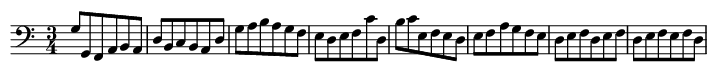

107/107 [==============================] - 15s 139ms/step - loss: 3.0948 - note_outputs_loss: 2.5141 - duration_outputs_loss: 0.5807
Epoch 8/20
107/107 [==============================] - ETA: 0s - loss: 3.0446 - note_outputs_loss: 2.4759 - duration_outputs_loss: 0.5687[['START', '3/4TS', 'D:major', '3/4TS'], ['0.0', '0.0', '0.0', '0.0']]


107/107 [==============================] - 9s 82ms/step - loss: 3.0446 - note_outputs_loss: 2.4759 - duration_outputs_loss: 0.5687
Epoch 9/20
107/107 [==============================] - ETA: 0s - loss: 3.0047 - note_outputs_loss: 2.4321 - duration_outputs_loss: 0.5726[['START', '3/4TS', '4/4TS', '4/4TS', 'D:major'], ['0.0', '0.0', '0.0', '0.0', '0.0']]


107/107 [==============================] - 9s 86ms/step - loss: 3.0047 - note_outputs_loss: 2.4321 - duration_outputs_loss: 0.5726
Epoch 10/20
107/107 [==============================] - ETA: 0s - loss: 2.9896 - note_outputs_loss: 2.4139 - duration_outputs_loss: 0.5757[['START', 'E-:major', 'E-:major', 'rest'], ['0.0', '1.0', '3.0', '1.0']]


107/107 [==============================] - 9s 85ms/step - loss: 2.9896 - note_outputs_loss: 2.4139 - duration_outputs_loss: 0.5757
Epoch 11/20
107/107 [==============================] - ETA: 0s - loss: 2.9365 - note_outputs_loss: 2.3818 - duration_outputs_loss: 0.5547[['START', '3/4TS'], ['0.0', '0.0']]


107/107 [==============================] - 9s 80ms/step - loss: 2.9365 - note_outputs_loss: 2.3818 - duration_outputs_loss: 0.5547
Epoch 12/20
107/107 [==============================] - ETA: 0s - loss: 2.9109 - note_outputs_loss: 2.3569 - duration_outputs_loss: 0.5540

[['START', 'C:major', '3/4TS', 'rest'], ['0.0', '0.0', '0.0', '3.75']]


107/107 [==============================] - 9s 84ms/step - loss: 2.9109 - note_outputs_loss: 2.3569 - duration_outputs_loss: 0.5540
Epoch 13/20
107/107 [==============================] - ETA: 0s - loss: 2.9082 - note_outputs_loss: 2.3464 - duration_outputs_loss: 0.5618[['START', '3/4TS', 'rest'], ['0.0', '0.0', '3.75']]


107/107 [==============================] - 9s 86ms/step - loss: 2.9082 - note_outputs_loss: 2.3464 - duration_outputs_loss: 0.5618
Epoch 14/20
107/107 [==============================] - ETA: 0s - loss: 2.8802 - note_outputs_loss: 2.3291 - duration_outputs_loss: 0.5511

[['START', 'E-:major', 'E-:major', '3/4TS', 'C4', 'D4', 'C4', 'B3', 'C4', 'B3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


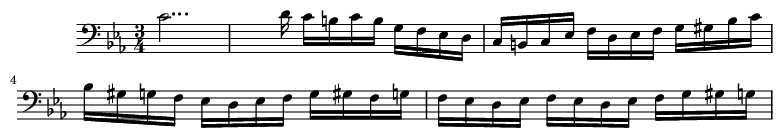

107/107 [==============================] - 15s 143ms/step - loss: 2.8802 - note_outputs_loss: 2.3291 - duration_outputs_loss: 0.5511
Epoch 15/20
107/107 [==============================] - ETA: 0s - loss: 2.8607 - note_outputs_loss: 2.3040 - duration_outputs_loss: 0.5567[['START', 'C:major', '3/4TS', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'C3', 'G#3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'E-3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


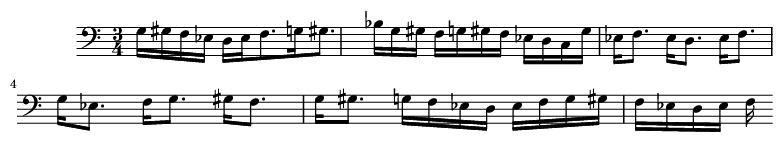

107/107 [==============================] - 16s 145ms/step - loss: 2.8607 - note_outputs_loss: 2.3040 - duration_outputs_loss: 0.5567
Epoch 16/20
107/107 [==============================] - ETA: 0s - loss: 2.8624 - note_outputs_loss: 2.3032 - duration_outputs_loss: 0.5592[['START', 'E-:major', '4/4TS', '4/4TS', '4/4TS', 'rest'], ['0.0', '0.0', '0.0', '0.0', '0.0', '3.75']]


107/107 [==============================] - 9s 86ms/step - loss: 2.8624 - note_outputs_loss: 2.3032 - duration_outputs_loss: 0.5592
Epoch 17/20
107/107 [==============================] - ETA: 0s - loss: 2.8342 - note_outputs_loss: 2.2808 - duration_outputs_loss: 0.5534[['START', 'E-:major', '4/4TS', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'E-3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'F3', 'E-3', 'D3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


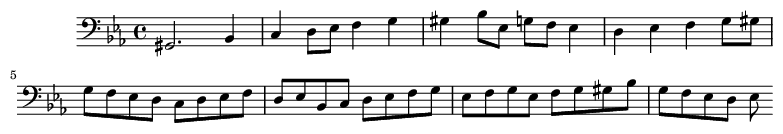

107/107 [==============================] - 15s 139ms/step - loss: 2.8342 - note_outputs_loss: 2.2808 - duration_outputs_loss: 0.5534
Epoch 18/20
107/107 [==============================] - ETA: 0s - loss: 2.8192 - note_outputs_loss: 2.2654 - duration_outputs_loss: 0.5539[['START', 'C:major', 'rest'], ['0.0', '2.5', '0.5']]


107/107 [==============================] - 9s 84ms/step - loss: 2.8192 - note_outputs_loss: 2.2654 - duration_outputs_loss: 0.5539
Epoch 19/20
107/107 [==============================] - ETA: 0s - loss: 2.7876 - note_outputs_loss: 2.2447 - duration_outputs_loss: 0.5429[['START', 'D:major', '4/4TS', 'D5', 'C#5', 'D5', 'C#5', 'D5', 'C#5', '6/8TS', 'E4', 'E4', 'E4', 'E4', 'F#4', 'G4', 'E4', 'E4', 'F#4', 'G4', 'E4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'D4', 'C#4', 'B3', 'C#4', 'B3', 'C#4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'C#4', 'B3', 'C#4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


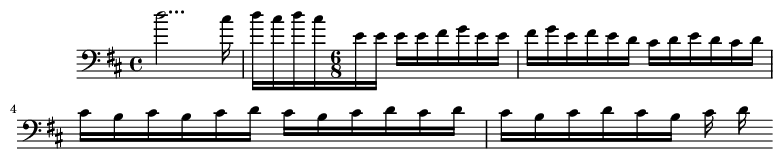

107/107 [==============================] - 15s 141ms/step - loss: 2.7876 - note_outputs_loss: 2.2447 - duration_outputs_loss: 0.5429
Epoch 20/20
107/107 [==============================] - ETA: 0s - loss: 2.7652 - note_outputs_loss: 2.2257 - duration_outputs_loss: 0.5395[['START', 'D:major', '3/4TS', 'rest'], ['0.0', '0.5', '0.5', '0.5']]


107/107 [==============================] - 9s 84ms/step - loss: 2.7652 - note_outputs_loss: 2.2257 - duration_outputs_loss: 0.5395


In [28]:
model.fit(
    ds,epochs=EPOCHS,
    callbacks = [
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator
    ]
)

In [29]:
model.save('/content/drive/MyDrive/music_transformer.pth')

- 트랜스포머를 사용하여 음악생성

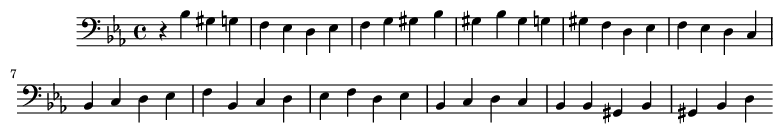

In [32]:
info = music_generator.generate(
    ['START'],['0.0'],max_tokens=50,temperature=0.5
)
midi_stream = info[-1]['midi'].chordify()
display(Image(str(midi_stream.write('lily.png'))))

- MIDI파일로 음악 저장

In [33]:
midi_stream.write(
    'midi',
    fp=os.path.join(
        './output',
        'output-'+timestr+'.mid'
    )
)

'./output/output-20240403-123040.mid'

 - 바흐 코랄 스타일로 음악을 생성

In [46]:
import sys

# 코랩의 경우 깃허브 저장소로부터 musegan_utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/02_musegan/musegan_utils.py
    # output 디렉토리를 만듭니다.
    !mkdir parsed_data
    !mkdir output
    !mkdir bach-chorales
    # 악보 이미지 생성을 위해
    !apt-get install lilypond > /dev/null

--2024-04-03 12:47:36--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/02_musegan/musegan_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1833 (1.8K) [text/plain]
Saving to: ‘musegan_utils.py’

musegan_utils.py    100%[===================>]   1.79K  --.-KB/s    in 0s      

2024-04-03 12:47:37 (24.4 MB/s) - ‘musegan_utils.py’ saved [1833/1833]

mkdir: cannot create directory ‘parsed_data’: File exists
mkdir: cannot create directory ‘output’: File exists


In [47]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import os
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    callbacks,
    initializers,
    metrics,
)

from musegan_utils import notes_to_midi, draw_score

- 파라메터셋팅

In [48]:
BATCH_SIZE = 64

N_BARS = 2
N_STEPS_PER_BAR = 16
MAX_PITCH = 83
N_PITCHES = MAX_PITCH + 1
Z_DIM = 32


CRITIC_STEPS = 5
GP_WEIGHT = 10
CRITIC_LEARNING_RATE = 0.001
GENERATOR_LEARNING_RATE = 0.001
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
EPOCHS = 1000
LOAD_MODEL = False

In [49]:
if 'google.colab' in sys.modules:
    !curl -LO https://github.com/czhuang/JSB-Chorales-dataset/raw/master/Jsb16thSeparated.npz -s
    !mv Jsb16thSeparated.npz bach-chorales

# 데이터 로드
file = os.path.join("./bach-chorales/Jsb16thSeparated.npz")
with np.load(file, encoding="bytes", allow_pickle=True) as f:
    data = f["train"]

N_SONGS = len(data)
print(f"데이터셋에 있는 코랄 개수: {N_SONGS}")
chorale = data[0]
N_BEATS, N_TRACKS = chorale.shape
print(f"코랄 0번의 크기: {N_BEATS, N_TRACKS}")
print("\n코랄 0")
print(chorale[:8])

two_bars = np.array([x[: (N_STEPS_PER_BAR * N_BARS)] for x in data])
two_bars = np.array(np.nan_to_num(two_bars, nan=MAX_PITCH), dtype=int)
two_bars = two_bars.reshape([N_SONGS, N_BARS, N_STEPS_PER_BAR, N_TRACKS])
print(f"두 마디 크기: {two_bars.shape}")

data_binary = np.eye(N_PITCHES)[two_bars]
data_binary[data_binary == 0] = -1
data_binary = data_binary.transpose([0, 1, 2, 4, 3])
print(f"데이터 바이너리 크기: {data_binary.shape}")


데이터셋에 있는 코랄 개수: 229
코랄 0번의 크기: (192, 4)

코랄 0
[[74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [75. 70. 58. 55.]
 [75. 70. 58. 55.]
 [75. 70. 60. 55.]
 [75. 70. 60. 55.]]
두 마디 크기: (229, 2, 16, 4)
데이터 바이너리 크기: (229, 2, 16, 84, 4)


- GAN 구축

In [50]:
# 헬퍼 함수

initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)


def conv(x, f, k, s, p):
    x = layers.Conv3D(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    x = layers.LeakyReLU()(x)
    return x


def conv_t(x, f, k, s, a, p, bn):
    x = layers.Conv2DTranspose(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)

    x = layers.Activation(a)(x)
    return x

In [51]:
def TemporalNetwork():
    input_layer = layers.Input(shape=(Z_DIM,), name="temporal_input")
    x = layers.Reshape([1, 1, Z_DIM])(input_layer)
    x = conv_t(x, f=1024, k=(2, 1), s=(1, 1), a="relu", p="valid", bn=True)
    x = conv_t(
        x, f=Z_DIM, k=(N_BARS - 1, 1), s=(1, 1), a="relu", p="valid", bn=True
    )
    output_layer = layers.Reshape([N_BARS, Z_DIM])(x)
    return models.Model(input_layer, output_layer)


TemporalNetwork().summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 temporal_input (InputLayer  [(None, 32)]              0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 1, 1024)        66560     
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 2, 1, 1024)        4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2, 1, 1024)        0         
                                                          

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
def BarGenerator():
    input_layer = layers.Input(shape=(Z_DIM * 4,), name="bar_generator_input")

    x = layers.Dense(1024)(input_layer)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.Activation("relu")(x)
    x = layers.Reshape([2, 1, 512])(x)

    x = conv_t(x, f=512, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(1, 7), s=(1, 7), a="relu", p="same", bn=True)
    x = conv_t(x, f=1, k=(1, 12), s=(1, 12), a="tanh", p="same", bn=False)

    output_layer = layers.Reshape([1, N_STEPS_PER_BAR, N_PITCHES, 1])(x)

    return models.Model(input_layer, output_layer)


BarGenerator().summary()

In [53]:
def Generator():
    chords_input = layers.Input(shape=(Z_DIM,), name="chords_input")
    style_input = layers.Input(shape=(Z_DIM,), name="style_input")
    melody_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="melody_input")
    groove_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="groove_input")

    # 코드 -> TemporalNetwork
    chords_tempNetwork = TemporalNetwork()
    chords_over_time = chords_tempNetwork(chords_input)  # [n_bars, z_dim]

    # 멜로디 -> TemporalNetwork
    melody_over_time = [
        None
    ] * N_TRACKS  # n_tracks개 [n_bars, z_dim] 텐서의 리스트
    melody_tempNetwork = [None] * N_TRACKS
    for track in range(N_TRACKS):
        melody_tempNetwork[track] = TemporalNetwork()
        melody_track = layers.Lambda(lambda x, track=track: x[:, track, :])(
            melody_input
        )
        melody_over_time[track] = melody_tempNetwork[track](melody_track)

    # 각 트랙에 대한 마디 생성자를 만듭니다.
    barGen = [None] * N_TRACKS
    for track in range(N_TRACKS):
        barGen[track] = BarGenerator()

    # 각 트랙과 마디에 대해 출력을 만듭니다.
    bars_output = [None] * N_BARS
    c = [None] * N_BARS
    for bar in range(N_BARS):
        track_output = [None] * N_TRACKS

        c[bar] = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
            chords_over_time
        )  # [z_dim]
        s = style_input  # [z_dim]

        for track in range(N_TRACKS):
            m = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
                melody_over_time[track]
            )  # [z_dim]
            g = layers.Lambda(lambda x, track=track: x[:, track, :])(
                groove_input
            )  # [z_dim]

            z_input = layers.Concatenate(
                axis=1, name="total_input_bar_{}_track_{}".format(bar, track)
            )([c[bar], s, m, g])

            track_output[track] = barGen[track](z_input)

        bars_output[bar] = layers.Concatenate(axis=-1)(track_output)

    generator_output = layers.Concatenate(axis=1, name="concat_bars")(
        bars_output
    )

    return models.Model(
        [chords_input, style_input, melody_input, groove_input],
        generator_output,
    )


generator = Generator()
generator.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 melody_input (InputLayer)   [(None, 4, 32)]              0         []                            
                                                                                                  
 chords_input (InputLayer)   [(None, 32)]                 0         []                            
                                                                                                  
 lambda (Lambda)             (None, 32)                   0         ['melody_input[0][0]']        
                                                                                                  
 lambda_1 (Lambda)           (None, 32)                   0         ['melody_input[0][0]']        
                                                                                           

In [54]:
def Critic():
    critic_input = layers.Input(
        shape=(N_BARS, N_STEPS_PER_BAR, N_PITCHES, N_TRACKS),
        name="critic_input",
    )

    x = critic_input

    x = conv(x, f=128, k=(2, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(N_BARS - 1, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(1, 1, 12), s=(1, 1, 12), p="same")
    x = conv(x, f=128, k=(1, 1, 7), s=(1, 1, 7), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=256, k=(1, 4, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=512, k=(1, 3, 1), s=(1, 2, 1), p="same")

    x = layers.Flatten()(x)

    x = layers.Dense(1024, kernel_initializer=initializer)(x)
    x = layers.LeakyReLU()(x)

    critic_output = layers.Dense(
        1, activation=None, kernel_initializer=initializer
    )(x)

    return models.Model(critic_input, critic_output)


critic = Critic()
critic.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 2, 16, 84, 4)]    0         
                                                                 
 conv3d (Conv3D)             (None, 1, 16, 84, 128)    1152      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 16, 84, 128)    16512     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 16, 7, 128)     196736    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1, 16, 7, 128)     0  

In [55]:
class MuseGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(MuseGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(MuseGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            chords_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            style_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            melody_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )
            groove_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )

            random_latent_vectors = [
                chords_random_latent_vectors,
                style_random_latent_vectors,
                melody_random_latent_vectors,
                groove_random_latent_vectors,
            ]

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        chords_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )

        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

    def generate_piano_roll(self, num_scores):
        chords_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]
        generated_music = self.generator(random_latent_vectors)
        generated_music = generated_music.numpy()
        return generated_music

In [56]:
# MuseGAN 만들기
musegan = MuseGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [57]:
if LOAD_MODEL:
    musegan.load_weights("./checkpoint/checkpoint.ckpt")

- MuseGAN 훈련



In [58]:
# GAN 컴파일
musegan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
)

In [59]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

from IPython.display import Image

class MusicGenerator(callbacks.Callback):
    def __init__(self, num_scores):
        self.num_scores = num_scores

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            generated_music = self.model.generate_piano_roll(self.num_scores)
            notes_to_midi(
                generated_music,
                N_BARS,
                N_TRACKS,
                N_STEPS_PER_BAR,
                filename="output_" + str(epoch).zfill(4),
            )
            display(Image(str(draw_score("output_" + str(epoch).zfill(4), 0).write('lily.png'))))
            # draw_score(generated_music, 0)
            # display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch), cmap = None)


music_generator_callback = MusicGenerator(1)

In [ ]:
history = musegan.fit(
    data_binary,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator_callback,
    ],
)

Epoch 1/1000
